In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks

In [3]:
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)

In [4]:
df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
df.drop('customerID', axis=1, inplace=True)

In [7]:
# Converting the object data type to numeric
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')

In [8]:
# Checking for null values

df.isnull().sum().sum()

11

In [9]:
# Null values are less so droping them

df.dropna(inplace=True)


In [10]:
# Converting the categorical fetaure into numeric

from sklearn.preprocessing import LabelEncoder, StandardScaler
le = LabelEncoder()

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col])


In [11]:
# Splitting the features and target variables

X = df.drop('Churn', axis=1)
y = df.Churn

In [12]:
# Feature selection using RFE

from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

rfe = RFE(DecisionTreeClassifier(), n_features_to_select=5, )

fit = rfe.fit(X, y)


In [13]:
cols = []
for col, rank in zip(X.columns, fit.ranking_):
    print(f'{col} -> {rank}')
    if rank <7:
        cols.append(col)

gender -> 3
SeniorCitizen -> 7
Partner -> 5
Dependents -> 9
tenure -> 1
PhoneService -> 15
MultipleLines -> 11
InternetService -> 4
OnlineSecurity -> 2
OnlineBackup -> 6
DeviceProtection -> 8
TechSupport -> 12
StreamingTV -> 13
StreamingMovies -> 14
Contract -> 1
PaperlessBilling -> 10
PaymentMethod -> 1
MonthlyCharges -> 1
TotalCharges -> 1


In [14]:
X = df[cols]

In [15]:
# Splitting the dataset for training and testing

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=100)

In [16]:
# Standardizing/Normilizing the dataset. 
sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled = sc.fit_transform(x_test)     

In [17]:
# Creating the ANN model

model = models.Sequential([
    layers.Dense(16, activation = 'relu', input_shape = (len(x_train_scaled[0]), )),
    layers.Dense(8, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
])

In [18]:
# Compiling the model, 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [19]:
# Early stopping to avoid overfitting

early_stopping = callbacks.EarlyStopping(patience=3, restore_best_weights= True)

In [ ]:
# Training the model with the data
history = model.fit(x_train_scaled, y_train, validation_split=0.10, epochs=30, batch_size=10, callbacks=[early_stopping])

Epoch 1/30
507/507 [==============================] - 4s 5ms/step - loss: 0.5046 - accuracy: 0.7313 - val_loss: 0.4389 - val_accuracy: 0.7549
Epoch 2/30
507/507 [==============================] - 2s 4ms/step - loss: 0.4431 - accuracy: 0.7699 - val_loss: 0.4229 - val_accuracy: 0.7780
Epoch 3/30
507/507 [==============================] - 2s 4ms/step - loss: 0.4297 - accuracy: 0.7916 - val_loss: 0.4185 - val_accuracy: 0.7922
Epoch 4/30
507/507 [==============================] - 2s 4ms/step - loss: 0.4248 - accuracy: 0.7942 - val_loss: 0.4144 - val_accuracy: 0.8064
Epoch 5/30
507/507 [==============================] - 2s 4ms/step - loss: 0.4219 - accuracy: 0.7955 - val_loss: 0.4107 - val_accuracy: 0.8064
Epoch 6/30
507/507 [==============================] - 2s 4ms/step - loss: 0.4203 - accuracy: 0.7983 - val_loss: 0.4098 - val_accuracy: 0.7993
Epoch 7/30
507/507 [==============================] - 3s 5ms/step - loss: 0.4184 - accuracy: 0.7983 - val_loss: 0.4118 - val_accuracy: 0.8082
Epoch 

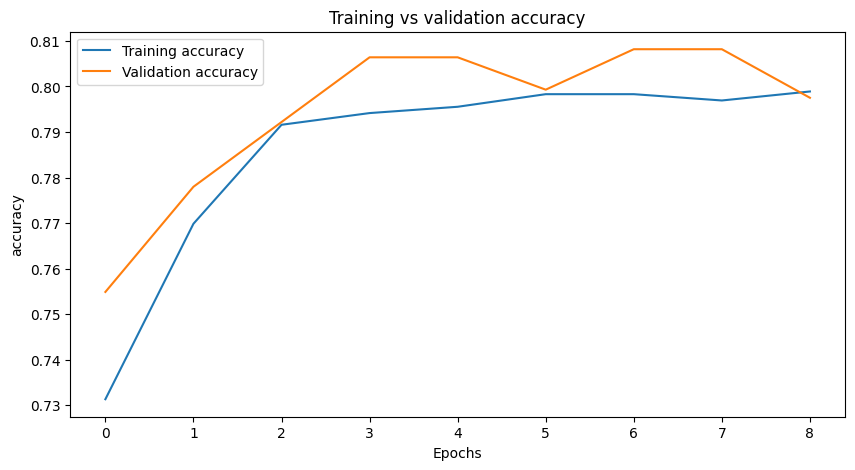

In [ ]:
# Visualizing the accuracy of the traing and validatin data.

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.title('Training vs validation accuracy')
plt.show()

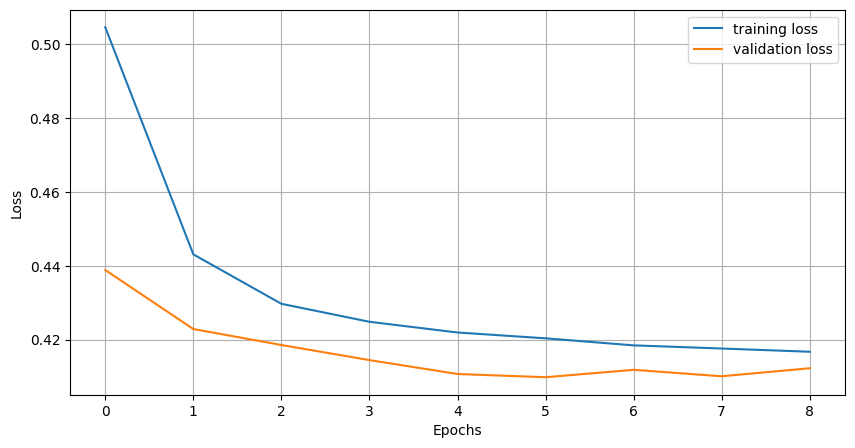

In [ ]:
# Visualizing the loss of training and validation data

plt.figure(figsize=(10,5))

plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()